<a href="https://colab.research.google.com/github/veridie/first-contributions/blob/master/Copy_of_Pset3_programming_182_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overall Setup [no changes]

Install dependancies and functions for displaying videos

Setup code source: StarAI



In [2]:
#CELL 1
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [3]:
#CELL 2
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[box2d] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (50.3.2)


In [4]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

#CELL 3

In [5]:
from pyvirtualdisplay import Display
#CELL 4

display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
#CELL 5

def show_video(folder):
  mp4list = glob.glob(folder+'/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env, folder):
  env = Monitor(env, './'+folder, force=True)
  return env

# Lunar Lander Setup! [no changes, but look at output]
For more information about the domain, visit
https://gym.openai.com/envs/LunarLander-v2/

In [7]:
#CELL 6
folder = 'video-test'
#create the lunar lander environment
env = wrap_env(gym.make("LunarLander-v2"),folder)

In [8]:
#CELL 7
#check out the lunar lander action space! 
#There are 8 states as defined in the GitHub, 6 of which are continuous and the final 2 are binary
print(env.observation_space.shape[0])
#There are 4 actions (fire the main engine, left engine, right engine, or do nothing)
print(env.action_space)

8
Discrete(4)


In [9]:
#CELL 8
#This is the baseline code to be able to implement the RL algorithms!
observation = env.reset()

while True:
    env.render()

    #your agent goes here
    action = env.action_space.sample()  #this is a random agent
         
    observation, reward, done, info = env.step(action) 
    
    if done: 
      break;        
env.close()
show_video(folder)

# Q-Learning Implementation

In [10]:
## Reward
## States / set up 

#CELL 9
#create the lunar lander environment

"""
TODO: Discretizing the continuous observation state space. The final two values
    are binary and therefore only have 2 values (0 or 1) but the other values 
    can be separated into any number of buckets (greater than 3).
    According to OpenAI "the useful range is -1 .. +1, but spikes can be higher"
"""

bucket_num = [4,3,3,3,3,3,2,2] #some default values! Set your own. 

def get_Q_state(state):
    """
    OPTIONAL: change the bucketing method!
    This method takes the state (a length 8 numpy array) from the environment
    and returns a string (the state string)encoding the discrete states 
    (formatted with dashes between values). 
    """
    assert(state.shape[0] == 8)

    bucket = [0. for index in range(8)]
    
    for index in range(8):
        if (index == 6 or index == 7):
            bucket[index] = int(state[index])
        else:
            #two big buckets for the extremes (<-2 or >2)
            if (state[index] <= -2):
                bucket[index] = 0
            elif (state[index] >= 2):
                bucket[index] = bucket_num[index]-1
            else: #several uniform buckets for the other indexes
                bucket[index] = int((state[index]+2)*bucket_num[index]//4)
    
    bucket_string = ""
    for index in range(8):
        bucket_string = bucket_string + str(bucket[index]) + "-"
    #returns a Q-bucket state that looks like 1-2-1-2-2-1-0-0_action
    return bucket_string[:-1]

In [48]:
#CELL 10
import random
from IPython.display import clear_output
import pickle

folder = 'video-final'
env = wrap_env(gym.make("LunarLander-v2"),folder)

"""
TODO: Writing the Q-Learning Algorithm to Train the Agent.
    1. Write the body of the Q-learning algorithm
    2. Tune the hyper-parameters and the values in bucket_num and have fun! 
"""

q_table = {}

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1
episodes = 1000

# For plotting metrics
all_epochs = [] #store the number of epochs per episode
all_rewards = [] #store the penalties per episode

# Get action given a state string
def get_action(state_string):
    # Initialize the reward for each action to null
    rewards = [None, None, None, None]
    # Iterate through all actions to find the best one
    for i in range(env.action_space.n):
        key = state_string + "_" + str(i)
        # get value of state, action
        value = q_table.get(key)
        # If state,action pair doesn't exist,create it and initialize it to 0
        if value == None:
            q_table[key] = 0
            rewards[i] = 0
        # otherwise retrieve value
        else:
            rewards[i] = value
    # Return max reward and the action that gives it. If tied then first action
    return max(rewards), rewards.index(max(rewards))


for i in range(0, episodes):
    state = env.reset()
    print(state) 
    epochs, total_reward = 0, 0
    done = False
    
    while not done:
        """
        You will find this code particularly helpful to get the next state from 
        your chosen action:
        next_state, reward, done, info = env.step(action)
        """
        # Get action that maximizes q value
        val_action, action = get_action(get_Q_state(state))
        
        # Try other paths with low frequency
        if random.uniform(0, 1) < epsilon:
          others = [j for j in range(4) if j != action]
          action = random.choice(others)
          val_action = q_table[(get_Q_state(state)+"_"+str(action))]
        
        # Next step
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        epochs += 1
        current_key = get_Q_state(state) + "_" + str(action)
        val_future, future = get_action(get_Q_state(next_state))
        # Update q values and move to next state
        q_table[current_key] = val_action + alpha * (reward + gamma * val_future - val_action)
        state = next_state

        
        
    if i % 50 == 0:
        clear_output(wait=True)
    print(f"Episode: {i},\t Epochs: {epochs},\tReward: {total_reward}")
    
    all_epochs.append(epochs)
    all_rewards.append(total_reward)

    if i % 1000 == 0: #adjust to save the q_table dictionary at checkpoints
        pickle.dump( q_table, open( "q_table.p", "wb" ) )
print("Training finished.\n")

Episode: 950,	 Epochs: 158,	Reward: 64.37508321627499
[-0.00510092  1.4173721  -0.5166899   0.28673628  0.00591756  0.11703812
  0.          0.        ]
Episode: 951,	 Epochs: 144,	Reward: -28.102223630387783
[-6.7548751e-04  1.4072859e+00 -6.8437569e-02 -1.6151388e-01
  7.8953424e-04  1.5502127e-02  0.0000000e+00  0.0000000e+00]
Episode: 952,	 Epochs: 118,	Reward: -124.18224098045053
[-0.00192928  1.4126954  -0.1954304   0.07890795  0.00224234  0.04426795
  0.          0.        ]
Episode: 953,	 Epochs: 172,	Reward: -174.0784013398141
[ 7.9336169e-04  1.4083831e+00  8.0345079e-02 -1.1275171e-01
 -9.1251842e-04 -1.8199351e-02  0.0000000e+00  0.0000000e+00]
Episode: 954,	 Epochs: 164,	Reward: -61.090588482755834
[-0.00587502  1.417632   -0.59509146  0.29828092  0.00681447  0.13479707
  0.          0.        ]
Episode: 955,	 Epochs: 121,	Reward: -9.554298489642107
[-0.00378485  1.418131   -0.38338     0.32047567  0.0043925   0.08684129
  0.          0.        ]
Episode: 956,	 Epochs: 119

Results after 100 episodes:
Average timesteps per episode: 73.86
Average reward per episode: -309.3596120909099


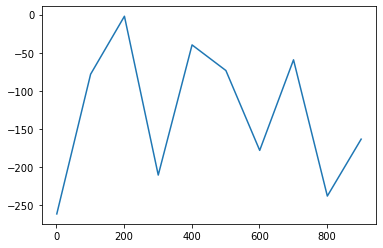

In [49]:
#CELL 11
"""
Some sample code to help you evaluate agent's performance after Q-learning!
Adjust accordingly to generate some nice metrics. 
This code will not be graded.
"""
import matplotlib.pyplot as plt
folder = 'video-eval'
env = wrap_env(gym.make("LunarLander-v2"),folder)
q_table = pickle.load( open( "q_table.p", "rb" ) )

total_epochs, total_reward = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, epoch_reward = 0, 0

    done = False
    
    while not done:
        state_string = get_Q_state(state)
        action_val, action = get_action(state_string)
        state, reward, done, info = env.step(action)

        epochs += 1
        epoch_reward += reward

    total_reward += epoch_reward
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average reward per episode: {total_reward / episodes}")
plt.plot([i+1 for i in range(0, len(all_rewards), 100)], all_rewards[::100])
plt.show()

In [46]:
#CELL 12
"""
TODO: Some sample code to help generate a video of a sample run! 
Adjust accordingly to generate some nice video files. 
This code will not be graded.
"""
folder = 'video-visual'
env = wrap_env(gym.make("LunarLander-v2"),folder)

state = env.reset()

while True:
    env.render()

    #your agent goes here
    state_string = get_Q_state(state)
    action_val, action = get_action(state_string)
    state, reward, done, info = env.step(action)
    
    if done: 
      break;        
env.close()
show_video(folder)